# Homework Challenge: A Triple SMA Crossover Stratetgy (Long-Short)

__Please proceed with the following steps:__

1. Understand the idea/rational behind a Triple SMA Crossover Strategy.

2. Load the dataset bitcoin.csv, prepare the data and define/calculate SMA_S = 15 (short), SMA_M = 50 (medium) and SMA_L = 200 (long). 

3. Remember, to calculate simple moving average prices, you have to use df.price.rolling() (see Section 7, Lecture "Rolling Statistics").

4. Define the Trading Positions and visualize Trading Positions over time.

5. Adjust the Long_Short_Backtester Frawework to the Triple SMA Crossover (hint: there are three strategy parameters: SMA_S, SMA_M, SMA_L)

6. Backtest the Triple SMA Strategy with the following inputs:

In [9]:
filepath = "bitcoin.csv"
symbol = "BTCUSDT"
start = "2017-08-17"
end = "2021-10-07"
tc = -0.00085
sma_s = 15
sma_m = 50
sma_l = 200

(The strategy multiple is:14.96014)

7. Repeat the Backtest with zero Trading Costs and compare.

(The strategy multiple with zero trading costs is: 37.528076)

8. Run the optimization (full period) in the following ranges:

In [10]:
SMA_S_range = (50, 300, 20) 
SMA_M_range = (500, 1500, 30)
SMA_L_range = (2000, 5000, 100)
metric = "Multiple"

(The optimal backtesting solution is: SMA_S: 170 | SMA_M: 1010 | SMA_L : 2400 | Multiple: 27.97009)

9. Adjust the LongShortTrader Framework and implement/run the Triple SMA Strategy with the following parameters:

In [11]:
symbol = "BTCUSDT"
bar_length = "1m"
sma_s = 10
sma_m = 20
sma_l = 50
units = 0.001
position = 0

10. Implement/run the Triple SMA Strategy with the following parameters:

In [12]:
symbol = "BTCUSDT"
bar_length = "1h"
sma_s = 15
sma_m = 50
sma_l = 200
units = 0.001
position = 0

Be careful here! (hint: check the historical data requirements!)

# ++++ Solution - Stop here if you want to do the exercise on your own! ++++

## Getting the data

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("seaborn")

In [14]:
data = pd.read_csv("bitcoin.csv", parse_dates = ["Date"], index_col = "Date")
data

,Open,High,Low,Close,Volume
Date,,,,,
2017-08-17 04:00:00,4261.48,4313.62,4261.32,4308.83,47.181009
2017-08-17 05:00:00,4308.83,4328.69,4291.37,4315.32,23.234916
2017-08-17 06:00:00,4330.29,4345.45,4309.37,4324.35,7.229691
2017-08-17 07:00:00,4316.62,4349.99,4287.41,4349.99,4.443249
2017-08-17 08:00:00,4333.32,4377.85,4333.32,4360.69,0.972807
...,...,...,...,...,...
2021-10-07 05:00:00,55073.20,55073.21,54545.07,54735.76,2251.122020
2021-10-07 06:00:00,54735.77,54968.06,54375.83,54534.16,1783.004260
2021-10-07 07:00:00,54534.16,54793.26,54235.33,54755.92,4163.431360


In [15]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 36168 entries, 2017-08-17 04:00:00 to 2021-10-07 09:00:00
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    36168 non-null  float64
 1   High    36168 non-null  float64
 2   Low     36168 non-null  float64
 3   Close   36168 non-null  float64
 4   Volume  36168 non-null  float64
dtypes: float64(5)
memory usage: 1.7 MB


In [16]:
data = data[["Close"]].copy()

In [17]:
data

,Close
Date,
2017-08-17 04:00:00,4308.83
2017-08-17 05:00:00,4315.32
2017-08-17 06:00:00,4324.35
2017-08-17 07:00:00,4349.99
2017-08-17 08:00:00,4360.69
...,...
2021-10-07 05:00:00,54735.76
2021-10-07 06:00:00,54534.16
2021-10-07 07:00:00,54755.92


In [18]:
data["returns"] = np.log(data.Close.div(data.Close.shift(1)))

In [19]:
data

,Close,returns
Date,,
2017-08-17 04:00:00,4308.83,NaN
2017-08-17 05:00:00,4315.32,0.001505
2017-08-17 06:00:00,4324.35,0.002090
2017-08-17 07:00:00,4349.99,0.005912
2017-08-17 08:00:00,4360.69,0.002457
...,...,...
2021-10-07 05:00:00,54735.76,-0.006146
2021-10-07 06:00:00,54534.16,-0.003690
2021-10-07 07:00:00,54755.92,0.004058


In [20]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 36168 entries, 2017-08-17 04:00:00 to 2021-10-07 09:00:00
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Close    36168 non-null  float64
 1   returns  36167 non-null  float64
dtypes: float64(2)
memory usage: 847.7 KB


## Formulating a Triple SMA Crossover Strategy

In [21]:
SMA_S = 15
SMA_M = 50
SMA_L = 200

In [22]:
data["SMA_S"] = data.Close.rolling(window = SMA_S).mean()
data["SMA_M"] = data.Close.rolling(window = SMA_M).mean()
data["SMA_L"] = data.Close.rolling(window = SMA_L).mean()

In [23]:
data

,Close,returns,SMA_S,SMA_M,SMA_L
Date,,,,,
2017-08-17 04:00:00,4308.83,NaN,NaN,NaN,NaN
2017-08-17 05:00:00,4315.32,0.001505,NaN,NaN,NaN
2017-08-17 06:00:00,4324.35,0.002090,NaN,NaN,NaN
2017-08-17 07:00:00,4349.99,0.005912,NaN,NaN,NaN
2017-08-17 08:00:00,4360.69,0.002457,NaN,NaN,NaN
...,...,...,...,...,...
2021-10-07 05:00:00,54735.76,-0.006146,54917.700667,52111.0732,47458.34450
2021-10-07 06:00:00,54534.16,-0.003690,54887.698667,52218.3902,47522.16155
2021-10-07 07:00:00,54755.92,0.004058,54878.672000,52327.0086,47586.68185


In [24]:
data.dropna(inplace = True)

In [25]:
smas = ["SMA_S", "SMA_M", "SMA_L"]
smas

['SMA_S', 'SMA_M', 'SMA_L']

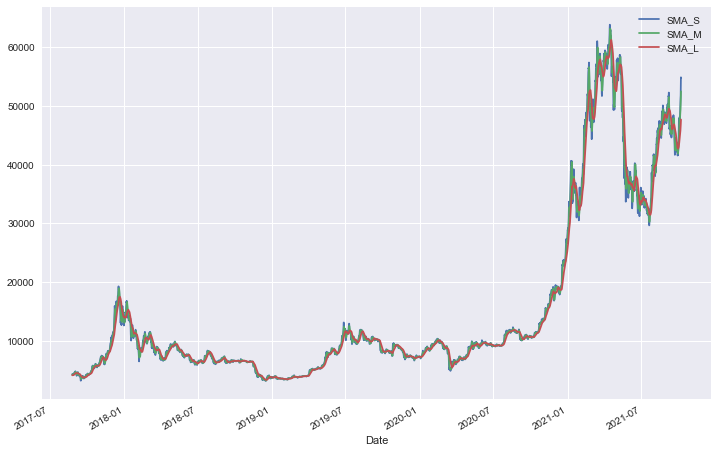

In [26]:
data[smas].plot(figsize = (12, 8))
plt.show()

In [27]:
data["position"] = 0 # Trading position -> Neutral for all bars
data

,Close,returns,SMA_S,SMA_M,SMA_L,position
Date,,,,,,
2017-08-25 11:00:00,4361.27,0.010821,4319.996000,4214.2724,4132.71175,0
2017-08-25 12:00:00,4309.69,-0.011897,4326.842000,4215.9058,4132.71605,0
2017-08-25 13:00:00,4312.00,0.000536,4325.893333,4217.3860,4132.69945,0
2017-08-25 14:00:00,4305.00,-0.001625,4325.159333,4219.1724,4132.60270,0
2017-08-25 15:00:00,4394.36,0.020545,4327.050000,4222.8396,4132.82455,0
...,...,...,...,...,...,...
2021-10-07 05:00:00,54735.76,-0.006146,54917.700667,52111.0732,47458.34450,0
2021-10-07 06:00:00,54534.16,-0.003690,54887.698667,52218.3902,47522.16155,0
2021-10-07 07:00:00,54755.92,0.004058,54878.672000,52327.0086,47586.68185,0


In [28]:
cond1 = (data.SMA_S > data.SMA_M) & (data.SMA_M > data.SMA_L)
cond1

Date
2017-08-25 11:00:00    True
2017-08-25 12:00:00    True
2017-08-25 13:00:00    True
2017-08-25 14:00:00    True
2017-08-25 15:00:00    True
                       ... 
2021-10-07 05:00:00    True
2021-10-07 06:00:00    True
2021-10-07 07:00:00    True
2021-10-07 08:00:00    True
2021-10-07 09:00:00    True
Length: 35969, dtype: bool

In [29]:
cond2 = (data.SMA_S < data.SMA_M) & (data.SMA_M < data.SMA_L)
cond2

Date
2017-08-25 11:00:00    False
2017-08-25 12:00:00    False
2017-08-25 13:00:00    False
2017-08-25 14:00:00    False
2017-08-25 15:00:00    False
                       ...  
2021-10-07 05:00:00    False
2021-10-07 06:00:00    False
2021-10-07 07:00:00    False
2021-10-07 08:00:00    False
2021-10-07 09:00:00    False
Length: 35969, dtype: bool

In [30]:
data.loc[cond1, "position"] = 1
data.loc[cond2, "position"] = -1

In [ ]:
data.position.value_counts()

In [ ]:
data[smas + ["position"]].plot(figsize = (12, 8), secondary_y = "position")
plt.show()

## Backtesting

In [ ]:
class Long_Short_Backtester():
    ''' Class for the vectorized backtesting of simple Long-Short trading strategies.
    
    Attributes
    ============
    filepath: str
        local filepath of the dataset (csv-file)
    symbol: str
        ticker symbol (instrument) to be backtested
    start: str
        start date for data import
    end: str
        end date for data import
    tc: float
        proportional trading costs per trade
    
    
    Methods
    =======
    get_data:
        imports the data.
        
    test_strategy:
        prepares the data and backtests the trading strategy incl. reporting (wrapper).
        
    prepare_data:
        prepares the data for backtesting.
    
    run_backtest:
        runs the strategy backtest.
        
    plot_results:
        plots the cumulative performance of the trading strategy compared to buy-and-hold.
        
    optimize_strategy:
        backtests strategy for different parameter values incl. optimization and reporting (wrapper).
    
    find_best_strategy:
        finds the optimal strategy (global maximum).
         
        
    print_performance:
        calculates and prints various performance metrics.
        
    '''    
    
    def __init__(self, filepath, symbol, start, end, tc):
        
        self.filepath = filepath
        self.symbol = symbol
        self.start = start
        self.end = end
        self.tc = tc
        self.results = None
        self.get_data()
        self.tp_year = (self.data.Close.count() / ((self.data.index[-1] - self.data.index[0]).days / 365.25))
        
    def __repr__(self):
        return "Long_Short_Backtester(symbol = {}, start = {}, end = {})".format(self.symbol, self.start, self.end)
        
    def get_data(self):
        ''' Imports the data.
        '''
        raw = pd.read_csv(self.filepath, parse_dates = ["Date"], index_col = "Date")
        raw = raw.loc[self.start:self.end].copy()
        raw["returns"] = np.log(raw.Close / raw.Close.shift(1))
        self.data = raw
        
    def test_strategy(self, smas):
        '''
        Prepares the data and backtests the trading strategy incl. reporting (Wrapper).
         
        Parameters
        ============
        smas: tuple (SMA_S, SMA_M, SMA_L)
            Simple Moving Averages to be considered for the strategy.
            
        '''
        
        self.SMA_S = smas[0]
        self.SMA_M = smas[1]
        self.SMA_L = smas[2]
        
        
        self.prepare_data(smas = smas)
        self.run_backtest()
        
        data = self.results.copy()
        data["creturns"] = data["returns"].cumsum().apply(np.exp)
        data["cstrategy"] = data["strategy"].cumsum().apply(np.exp)
        self.results = data
        
        self.print_performance()
    
    def prepare_data(self, smas):
        ''' Prepares the Data for Backtesting.
        '''
        ########################## Strategy-Specific #############################
        
        data = self.data[["Close", "returns"]].copy()
        data["SMA_S"] = data.Close.rolling(window = smas[0]).mean()
        data["SMA_M"] = data.Close.rolling(window = smas[1]).mean()
        data["SMA_L"] = data.Close.rolling(window = smas[2]).mean()
        
        data.dropna(inplace = True)
                
        cond1 = (data.SMA_S > data.SMA_M) & (data.SMA_M > data.SMA_L)
        cond2 = (data.SMA_S < data.SMA_M) & (data.SMA_M < data.SMA_L)
        
        data["position"] = 0
        data.loc[cond1, "position"] = 1
        data.loc[cond2, "position"] = -1

        ##########################################################################
        
        self.results = data
    
    def run_backtest(self):
        ''' Runs the strategy backtest.
        '''
        
        data = self.results.copy()
        data["strategy"] = data["position"].shift(1) * data["returns"]
        data["trades"] = data.position.diff().fillna(0).abs()
        data.strategy = data.strategy + data.trades * self.tc
        
        self.results = data
    
    def plot_results(self):
        '''  Plots the cumulative performance of the trading strategy compared to buy-and-hold.
        '''
        if self.results is None:
            print("Run test_strategy() first.")
        else:
            title = "{} | TC = {}".format(self.symbol, self.tc)
            self.results[["creturns", "cstrategy"]].plot(title=title, figsize=(12, 8))
            
    def optimize_strategy(self, SMA_S_range, SMA_M_range, SMA_L_range, metric = "Multiple"):
        '''
        Backtests strategy for different parameter values incl. Optimization and Reporting (Wrapper).
         
        Parameters
        ============
        SMA_S_range: tuple
            tuples of the form (start, end, step size).
        
        SMA_M_range: tuple
            tuples of the form (start, end, step size).
            
        SMA_L_range: tuple
            tuples of the form (start, end, step size).
        
        metric: str
            performance metric to be optimized (can be "Multiple" or "Sharpe")
        '''
        
        self.metric = metric
        
        if metric == "Multiple":
            performance_function = self.calculate_multiple
        elif metric == "Sharpe":
            performance_function = self.calculate_sharpe
        
        SMA_S_range = range(*SMA_S_range)
        SMA_M_range = range(*SMA_M_range)
        SMA_L_range = range(*SMA_L_range)
        
        combinations = list(product(SMA_S_range, SMA_M_range, SMA_L_range))
         
        performance = []
        for comb in combinations:
            self.prepare_data(smas = comb)
            self.run_backtest()
            performance.append(performance_function(self.results.strategy))
    
        self.results_overview =  pd.DataFrame(data = np.array(combinations), columns = ["SMA_S", "SMA_M", "SMA_L"])
        self.results_overview["performance"] = performance
        self.find_best_strategy()
        
        
    def find_best_strategy(self):
        ''' Finds the optimal strategy (global maximum).
        '''
        
        best = self.results_overview.nlargest(1, "performance")
        SMA_S = best.SMA_S.iloc[0]
        SMA_M = best.SMA_M.iloc[0]
        SMA_L = best.SMA_L.iloc[0]
        perf = best.performance.iloc[0]
        print("SMA_S: {} | SMA_M: {} | SMA_L : {} | {}: {}".format(SMA_S, SMA_M, SMA_L, self.metric, round(perf, 5)))  
        self.test_strategy(smas = (SMA_S, SMA_M, SMA_L))
            
    ############################## Performance ######################################
    
    def print_performance(self):
        ''' Calculates and prints various Performance Metrics.
        '''
        
        data = self.results.copy()
        strategy_multiple = round(self.calculate_multiple(data.strategy), 6)
        bh_multiple =       round(self.calculate_multiple(data.returns), 6)
        outperf =           round(strategy_multiple - bh_multiple, 6)
        cagr =              round(self.calculate_cagr(data.strategy), 6)
        ann_mean =          round(self.calculate_annualized_mean(data.strategy), 6)
        ann_std =           round(self.calculate_annualized_std(data.strategy), 6)
        sharpe =            round(self.calculate_sharpe(data.strategy), 6)
       
        print(100 * "=")
        print("TRIPLE SMA STRATEGY | INSTRUMENT = {} | SMAs = {}".format(self.symbol, [self.SMA_S, self.SMA_M, self.SMA_L]))
        print(100 * "-")
        print("PERFORMANCE MEASURES:")
        print("\n")
        print("Multiple (Strategy):         {}".format(strategy_multiple))
        print("Multiple (Buy-and-Hold):     {}".format(bh_multiple))
        print(38 * "-")
        print("Out-/Underperformance:       {}".format(outperf))
        print("\n")
        print("CAGR:                        {}".format(cagr))
        print("Annualized Mean:             {}".format(ann_mean))
        print("Annualized Std:              {}".format(ann_std))
        print("Sharpe Ratio:                {}".format(sharpe))
        
        print(100 * "=")
        
    def calculate_multiple(self, series):
        return np.exp(series.sum())
    
    def calculate_cagr(self, series):
        return np.exp(series.sum())**(1/((series.index[-1] - series.index[0]).days / 365.25)) - 1
    
    def calculate_annualized_mean(self, series):
        return series.mean() * self.tp_year
    
    def calculate_annualized_std(self, series):
        return series.std() * np.sqrt(self.tp_year)
    
    def calculate_sharpe(self, series):
        if series.std() == 0:
            return np.nan
        else:
            return self.calculate_cagr(series) / self.calculate_annualized_std(series)

In [7]:
filepath = "bitcoin.csv"
symbol = "BTCUSDT"
start = "2017-08-17"
end = "2021-10-07"
tc = -0.00085
sma_s = 15 
sma_m = 50 
sma_l = 200 

In [8]:
tester = Long_Short_Backtester(filepath = filepath, symbol = symbol,
                              start = start, end = end, tc = tc)

NameError: name 'Long_Short_Backtester' is not defined

In [ ]:
tester.data

In [ ]:
tester.test_strategy(smas = (sma_s, sma_m, sma_l))

In [ ]:
tester.plot_results()

In [ ]:
tester.results

In [ ]:
tester.results.trades.value_counts()

## Optimization

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import product
import warnings
warnings.filterwarnings("ignore")
plt.style.use("seaborn")

In [ ]:
tester.optimize_strategy(SMA_S_range = (50, 300, 20), 
                         SMA_M_range = (500, 1500, 30),
                         SMA_L_range = (2000, 5000, 100),
                         metric = "Multiple")

In [ ]:
tester.plot_results()

In [ ]:
tester.results

## Implementation

In [ ]:
from binance.client import Client
from binance import ThreadedWebsocketManager
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import time

In [ ]:
api_key = "insert here"
secret_key = "insert here"

In [ ]:
client = Client(api_key = api_key, api_secret = secret_key, tld = "com", testnet = True)

In [ ]:
class LongShortTrader():
    
    def __init__(self, symbol, bar_length, sma_s, sma_m, sma_l, units, position = 0):
        
        self.symbol = symbol
        self.bar_length = bar_length
        self.available_intervals = ["1m", "3m", "5m", "15m", "30m", "1h", "2h", "4h", "6h", "8h", "12h", "1d", "3d", "1w", "1M"]
        self.units = units
        self.position = position
        self.trades = 0 
        self.trade_values = []
        
        #*****************add strategy-specific attributes here******************
        self.SMA_S = sma_s
        self.SMA_M = sma_m
        self.SMA_L = sma_l
        #************************************************************************
    
    def start_trading(self, historical_days):
        
        self.twm = ThreadedWebsocketManager()
        self.twm.start()
        
        if self.bar_length in self.available_intervals:
            self.get_most_recent(symbol = self.symbol, interval = self.bar_length,
                                 days = historical_days)
            self.twm.start_kline_socket(callback = self.stream_candles,
                                        symbol = self.symbol, interval = self.bar_length)
        # "else" to be added later in the course 
    
    def get_most_recent(self, symbol, interval, days):
    
        now = datetime.utcnow()
        past = str(now - timedelta(days = days))
    
        bars = client.get_historical_klines(symbol = symbol, interval = interval,
                                            start_str = past, end_str = None, limit = 1000)
        df = pd.DataFrame(bars)
        df["Date"] = pd.to_datetime(df.iloc[:,0], unit = "ms")
        df.columns = ["Open Time", "Open", "High", "Low", "Close", "Volume",
                      "Clos Time", "Quote Asset Volume", "Number of Trades",
                      "Taker Buy Base Asset Volume", "Taker Buy Quote Asset Volume", "Ignore", "Date"]
        df = df[["Date", "Open", "High", "Low", "Close", "Volume"]].copy()
        df.set_index("Date", inplace = True)
        for column in df.columns:
            df[column] = pd.to_numeric(df[column], errors = "coerce")
        df["Complete"] = [True for row in range(len(df)-1)] + [False]
        
        self.data = df
    
    def stream_candles(self, msg):
        
        # extract the required items from msg
        event_time = pd.to_datetime(msg["E"], unit = "ms")
        start_time = pd.to_datetime(msg["k"]["t"], unit = "ms")
        first   = float(msg["k"]["o"])
        high    = float(msg["k"]["h"])
        low     = float(msg["k"]["l"])
        close   = float(msg["k"]["c"])
        volume  = float(msg["k"]["v"])
        complete=       msg["k"]["x"]
    
        # stop trading session
        if self.trades >= 5: # stop stream after 5 trades
            self.twm.stop()
            if self.position == 1:
                order = client.create_order(symbol = self.symbol, side = "SELL", type = "MARKET", quantity = self.units)
                self.report_trade(order, "GOING NEUTRAL AND STOP")
                self.position = 0
            elif self.position == -1:
                order = client.create_order(symbol = self.symbol, side = "BUY", type = "MARKET", quantity = self.units)
                self.report_trade(order, "GOING NEUTRAL AND STOP")
                self.position = 0
            else: 
                print("STOP")
        
        # print out
        print(".", end = "", flush = True) # just print something to get a feedback (everything OK) 
    
        # feed df (add new bar / update latest bar)
        self.data.loc[start_time] = [first, high, low, close, volume, complete]
        
        # prepare features and define strategy/trading positions whenever the latest bar is complete
        if complete == True:
            self.define_strategy()
            self.execute_trades()
        
    def define_strategy(self):
        
        data = self.data.copy()
        
        #******************** define your strategy here ************************
        data = data[["Close"]].copy()
        
        data["SMA_S"] = data.Close.rolling(window = self.SMA_S).mean()
        data["SMA_M"] = data.Close.rolling(window = self.SMA_M).mean()
        data["SMA_L"] = data.Close.rolling(window = self.SMA_L).mean()
        
        data.dropna(inplace = True)
                
        cond1 = (data.SMA_S > data.SMA_M) & (data.SMA_M > data.SMA_L)
        cond2 = (data.SMA_S < data.SMA_M) & (data.SMA_M < data.SMA_L)
        
        data["position"] = 0
        data.loc[cond1, "position"] = 1
        data.loc[cond2, "position"] = -1
        #***********************************************************************
        
        self.prepared_data = data.copy()
    
    def execute_trades(self): 
        if self.prepared_data["position"].iloc[-1] == 1: # if position is long -> go/stay long
            if self.position == 0:
                order = client.create_order(symbol = self.symbol, side = "BUY", type = "MARKET", quantity = self.units)
                self.report_trade(order, "GOING LONG")  
            elif self.position == -1:
                order = client.create_order(symbol = self.symbol, side = "BUY", type = "MARKET", quantity = self.units)
                self.report_trade(order, "GOING NEUTRAL")
                time.sleep(1)
                order = client.create_order(symbol = self.symbol, side = "BUY", type = "MARKET", quantity = self.units)
                self.report_trade(order, "GOING LONG")
            self.position = 1
        elif self.prepared_data["position"].iloc[-1] == 0: # if position is neutral -> go/stay neutral
            if self.position == 1:
                order = client.create_order(symbol = self.symbol, side = "SELL", type = "MARKET", quantity = self.units)
                self.report_trade(order, "GOING NEUTRAL") 
            elif self.position == -1:
                order = client.create_order(symbol = self.symbol, side = "BUY", type = "MARKET", quantity = self.units)
                self.report_trade(order, "GOING NEUTRAL") 
            self.position = 0
        if self.prepared_data["position"].iloc[-1] == -1: # if position is short -> go/stay short
            if self.position == 0:
                order = client.create_order(symbol = self.symbol, side = "SELL", type = "MARKET", quantity = self.units)
                self.report_trade(order, "GOING SHORT") 
            elif self.position == 1:
                order = client.create_order(symbol = self.symbol, side = "SELL", type = "MARKET", quantity = self.units)
                self.report_trade(order, "GOING NEUTRAL")
                time.sleep(1)
                order = client.create_order(symbol = self.symbol, side = "SELL", type = "MARKET", quantity = self.units)
                self.report_trade(order, "GOING SHORT")
            self.position = -1
    
    def report_trade(self, order, going): 
        
        # extract data from order object
        side = order["side"]
        time = pd.to_datetime(order["transactTime"], unit = "ms")
        base_units = float(order["executedQty"])
        quote_units = float(order["cummulativeQuoteQty"])
        price = round(quote_units / base_units, 5)
        
        # calculate trading profits
        self.trades += 1
        if side == "BUY":
            self.trade_values.append(-quote_units)
        elif side == "SELL":
            self.trade_values.append(quote_units) 
        
        if self.trades % 2 == 0:
            real_profit = round(np.sum(self.trade_values[-2:]), 3) 
            self.cum_profits = round(np.sum(self.trade_values), 3)
        else: 
            real_profit = 0
            self.cum_profits = round(np.sum(self.trade_values[:-1]), 3)
        
        # print trade report
        print(2 * "\n" + 100* "-")
        print("{} | {}".format(time, going)) 
        print("{} | Base_Units = {} | Quote_Units = {} | Price = {} ".format(time, base_units, quote_units, price))
        print("{} | Profit = {} | CumProfits = {} ".format(time, real_profit, self.cum_profits))
        print(100 * "-" + "\n")

In [ ]:
symbol = "BTCUSDT"
bar_length = "1m"
sma_s = 10
sma_m = 20
sma_l = 50
units = 0.001
position = 0

In [ ]:
client.get_account()

In [ ]:
trader = LongShortTrader(symbol = symbol, bar_length = bar_length, sma_s = sma_s, sma_m = sma_m, sma_l = sma_l,
                         units = units, position = position)

In [ ]:
trader.start_trading(historical_days = 1/24)

In [ ]:
trader.twm.stop()

In [ ]:
trader.prepared_data

__Implementation 2__

In [ ]:
symbol = "BTCUSDT"
bar_length = "1h"
sma_s = 15
sma_m = 50
sma_l = 200
units = 0.001
position = 0

In [ ]:
trader = LongShortTrader(symbol = symbol, bar_length = bar_length, sma_s = sma_s, sma_m = sma_m, sma_l = sma_l,
                         units = units, position = position)

We need at least 200 hours of historical data -> 9 days

In [ ]:
trader.start_trading(historical_days = 9)

In [ ]:
trader.twm.stop()